In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr, pearsonr
import seaborn as sns
from sklearn.decomposition import PCA
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import shap
import random
import itertools
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

RESOLUTION = 25
window_size = 401

assays = ['DNase', 'H3K36me3', 'H3K27me3', 'H3K27ac', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'Methylation_pos', 'Methylation_neg', 'MNase']

In [2]:
colnames = ["pos_" + str(x) for x in list(range(-(window_size//2), (window_size//2) + 1))]
colnames = colnames + ["log10p1(TPM)", "cell_type", "chrom", "position", "strand", "assay_index"] 
# df = pd.read_csv('../Data/Training_Data.for_Yun.csv', sep=",", names=colnames, low_memory=False)
df = pd.read_csv('../Data/MNase.Training_Data.csv', sep=",", names=colnames, low_memory=False)

# now append the CXCR4 and TGFBR1 features
# df = pd.concat([df, df_special])

df

,pos_-200,pos_-199,pos_-198,pos_-197,pos_-196,pos_-195,pos_-194,pos_-193,pos_-192,pos_-191,...,pos_197,pos_198,pos_199,pos_200,log10p1(TPM),cell_type,chrom,position,strand,assay_index
0,0.578652,0.616361,0.653577,0.641532,0.617677,0.620312,0.633544,0.617677,0.578653,0.591554,...,0.403987,0.395240,0.421756,0.449084,0.0,T13,chr1,46955,+,1
1,0.400741,0.400741,0.400741,0.400741,0.400741,0.400741,0.400741,0.400741,0.400741,0.400741,...,0.420688,0.415223,0.400741,0.400741,0.0,T13,chr1,46955,+,2
2,0.353071,0.347489,0.332627,0.377797,0.291447,0.328523,0.361822,0.387001,0.388386,0.355295,...,0.425095,0.415723,0.436474,0.395442,0.0,T13,chr1,46955,+,3
3,0.347780,0.347780,0.347780,0.347780,0.341266,0.345180,0.347780,0.330775,0.309184,0.315904,...,0.376839,0.376839,0.376839,0.376839,0.0,T13,chr1,46955,+,4
4,0.303918,0.287580,0.287580,0.292996,0.309118,0.306110,0.301085,0.313418,0.369105,0.378970,...,0.326380,0.326380,0.326380,0.326380,0.0,T13,chr1,46955,+,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106195,0.756888,0.813601,1.089862,1.102051,1.104208,1.061381,1.016406,0.747131,0.631313,0.512288,...,0.381220,0.381220,0.413746,0.453687,0.0,T13,chr22,2019474,+,6
106196,0.415712,0.464243,0.482745,0.482745,0.517002,0.482745,0.482745,0.474841,0.426616,0.440150,...,0.482745,0.482745,0.410262,0.369604,0.0,T13,chr22,2019474,+,7
106197,2.662588,0.000000,2.197225,2.833213,0.000000,1.609438,2.564949,1.609438,0.000000,1.609438,...,0.000000,0.000000,0.000000,0.000000,0.0,T13,chr22,2019474,+,8
106198,0.000000,0.000000,1.609438,2.564949,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,T13,chr22,2019474,+,9


In [3]:
# # Divide the data frame into quantiles and only go ahead with the one that contains a particular TPM
# TPM_of_interest = 12 # CXCR4 and 0.6 for TGFBR1

# num_quantiles = 2
# logTPM_quantiles = [df["log10p1(TPM)"].drop_duplicates().quantile(x) for x in np.arange(0, 1, 1.0/(num_quantiles * 1.0))]
# logTPM_quantiles = logTPM_quantiles + [np.power(10,10)]
# TPM_quantiles = [np.power(10, x)-1 for x in logTPM_quantiles]
# print(list(zip(logTPM_quantiles, TPM_quantiles)))


# for i in range(1, len(TPM_quantiles)):
#     if ((TPM_of_interest >= TPM_quantiles[i-1]) and (TPM_of_interest < TPM_quantiles[i])):
#         break

# df_quantiled = df[(df["log10p1(TPM)"] >= logTPM_quantiles[i-1]) & (df["log10p1(TPM)"] <= logTPM_quantiles[i])]

# Don't do any gene expression quantiling for now!
df_quantiled = df


cell_type = "T100"

operative_half_window_size = 80 # will lead to a total of 2*operative_half_window_size + 1 features
pairwise_flag = True # If true then H3K27ac features will be concatentated with assays[assay_index-1]

df_modeling = df_quantiled[(df_quantiled["cell_type"] != cell_type) & (df_quantiled["cell_type"] != cell_type)]
df_sorted = df_modeling.sort_values(['chrom', 'position', 'cell_type', 'assay_index'], ascending=[1, 1, 1, 1])
df_sorted_unique = df_sorted.drop_duplicates()

print("Finished sorting dataframe")


Finished sorting dataframe


100%|██████████| 10626/10626 [00:14<00:00, 732.26it/s]


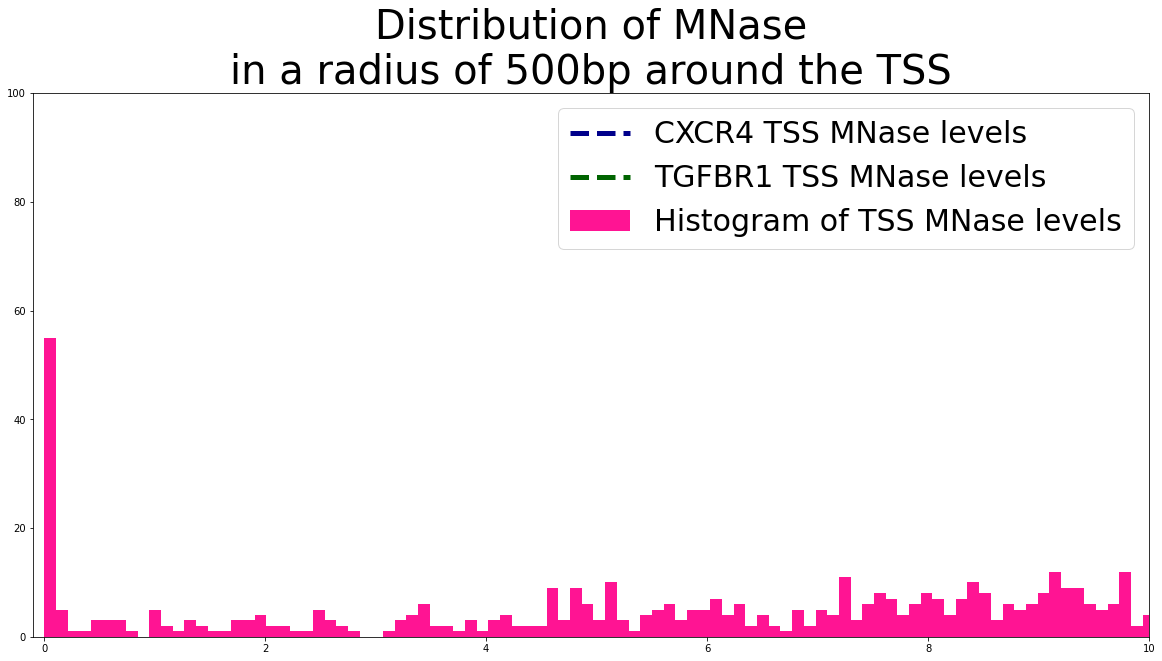

In [4]:
# Understanding the covariation of H3K27ac with DNA Methylation
assay_index_choice = 10 # Methylation_neg
df_H3K27ac = df_sorted_unique.iloc[range(4-1, len(df_sorted_unique), len(assays)), :]
df_other_assay = df_sorted_unique.iloc[range(assay_index_choice-1, len(df_sorted_unique), len(assays)), :]
df_merged = pd.merge(df_H3K27ac, df_other_assay, how='inner', on=['cell_type', 'chrom', 'position', 'strand'], suffixes=['_H3K27ac', '_'+assays[assay_index_choice-1]])

middle_position_first_feature = window_size // 2
middle_position_second_feature = -1 + ( (window_size + 6) + (window_size + 6 + window_size + 1) )//2

methylation_level = []
methylation_width = 20
for i in tqdm(range(min(100000, len(df_merged)))):
    methylation_level.append((i, np.sum( df_merged.iloc[i, 
                                                    middle_position_second_feature-(methylation_width):
                                                    middle_position_second_feature+(methylation_width)+1,] )))
methylation_level = np.asarray(methylation_level)

# Compute methylation level of CXCR4 and TGFBR1
x = np.load("../Data/CXCR4.npy")
CXCR4_methylation_neg = x[0, :, assay_index_choice-1]
l = len(CXCR4_methylation_neg)
CXCR4_TSS_methylation_level = np.sum(CXCR4_methylation_neg[(l//2)-(methylation_width):(l//2)+(methylation_width)])


x = np.load("../Data/TGFBR1.npy")
TGFBR1_methylation_neg = x[0, :, assay_index_choice-1]
l = len(TGFBR1_methylation_neg)
TGFBR1_TSS_methylation_level = np.sum(TGFBR1_methylation_neg[(l//2)-(methylation_width):(l//2)+(methylation_width)])

plt.rcParams["figure.figsize"] = (20, 10)
plt.hist(methylation_level[:, 1], bins=1000, color='#FF1493', label="Histogram of TSS "+str(assays[assay_index_choice-1])+" levels")
plt.xlim(-0.1, 10)
plt.ylim(0, 100)

plt.axvline(x=CXCR4_TSS_methylation_level, color="darkblue", linewidth=5, linestyle='--', label="CXCR4 TSS "+str(assays[assay_index_choice-1])+" levels")
plt.axvline(x=TGFBR1_TSS_methylation_level, color="darkgreen", linewidth=5, linestyle='--', label="TGFBR1 TSS "+str(assays[assay_index_choice-1])+" levels")

plt.legend(loc='upper right', prop={'size': 30}, ncol=1)

plt.title("Distribution of "+str(assays[assay_index_choice-1])+"\nin a radius of "+str(methylation_width*RESOLUTION)+"bp around the TSS", fontsize=40)
plt.show()

In [ ]:
a = methylation_level[:, 1]
b = df_merged['log10p1(TPM)_Methylation_neg']
plt.plot(a, b, 'o', alpha = 0.5, markersize=0.5)
plt.xlim(0, 10)
pc, pp = pearsonr(a, b)
sc, sp = spearmanr(a, b)
plt.title(str(round(pc, 2))+" ("+str(round(pp, 5))+") "+str(round(sc, 2))+" ("+str(round(sp, 5))+")", fontsize=50)
plt.show()

-1.0 69999.0
[-0.0001, 3]


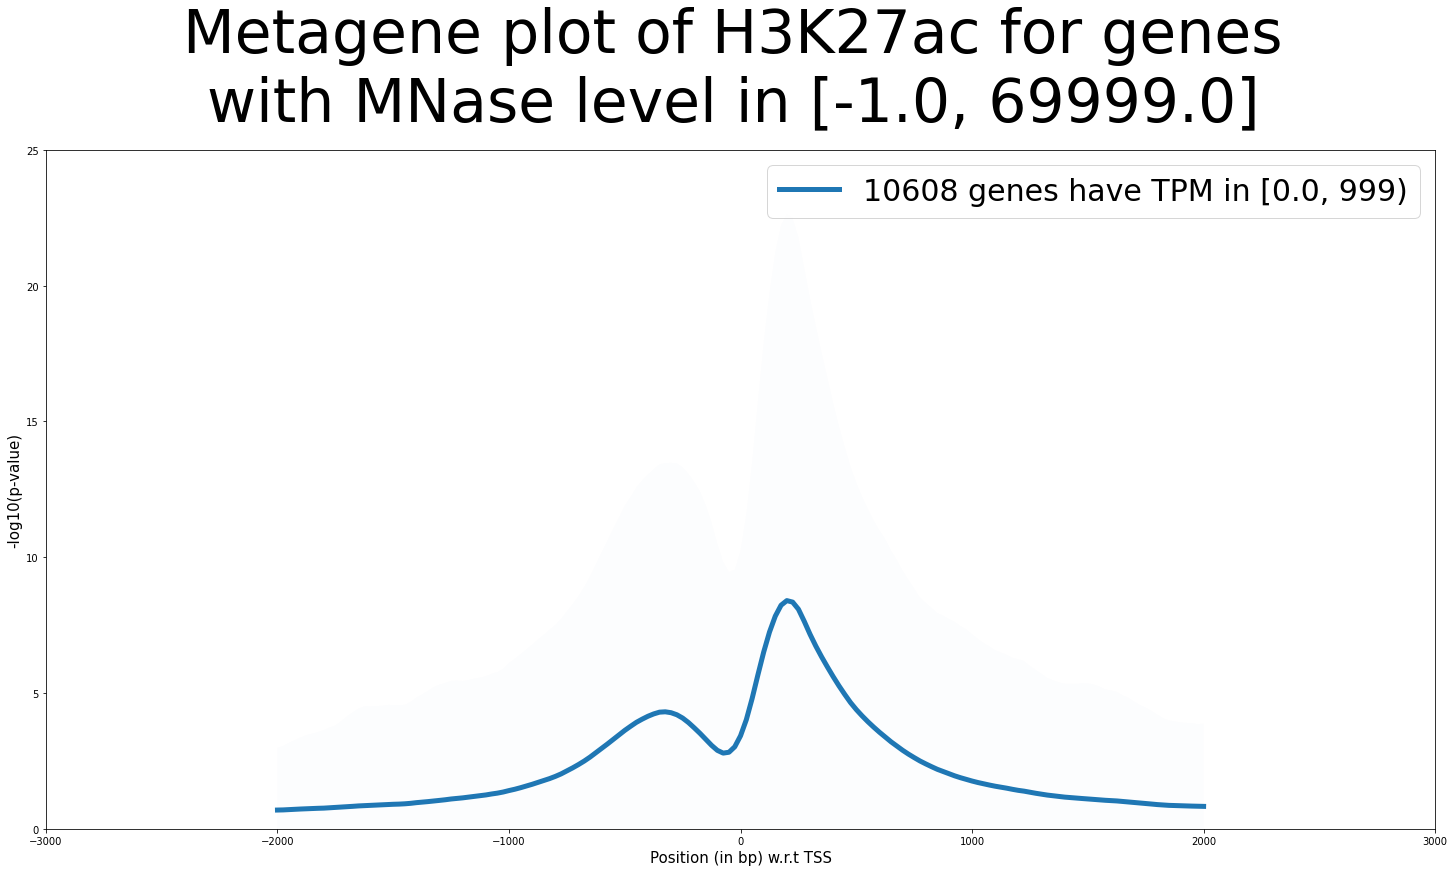

Quantile  1
(9462, 323) (5736, 323) (9462,) (5736,)
Train: MSE =  0.191 Pearson = 0.622 Spearman = 0.674
Test: MSE =  0.19 Pearson = 0.634 Spearman = 0.684
Predicted TPM for  CXCR4  =  1.8722657780598557
Predicted TPM for  TGFBR1  =  1.4939464037562358


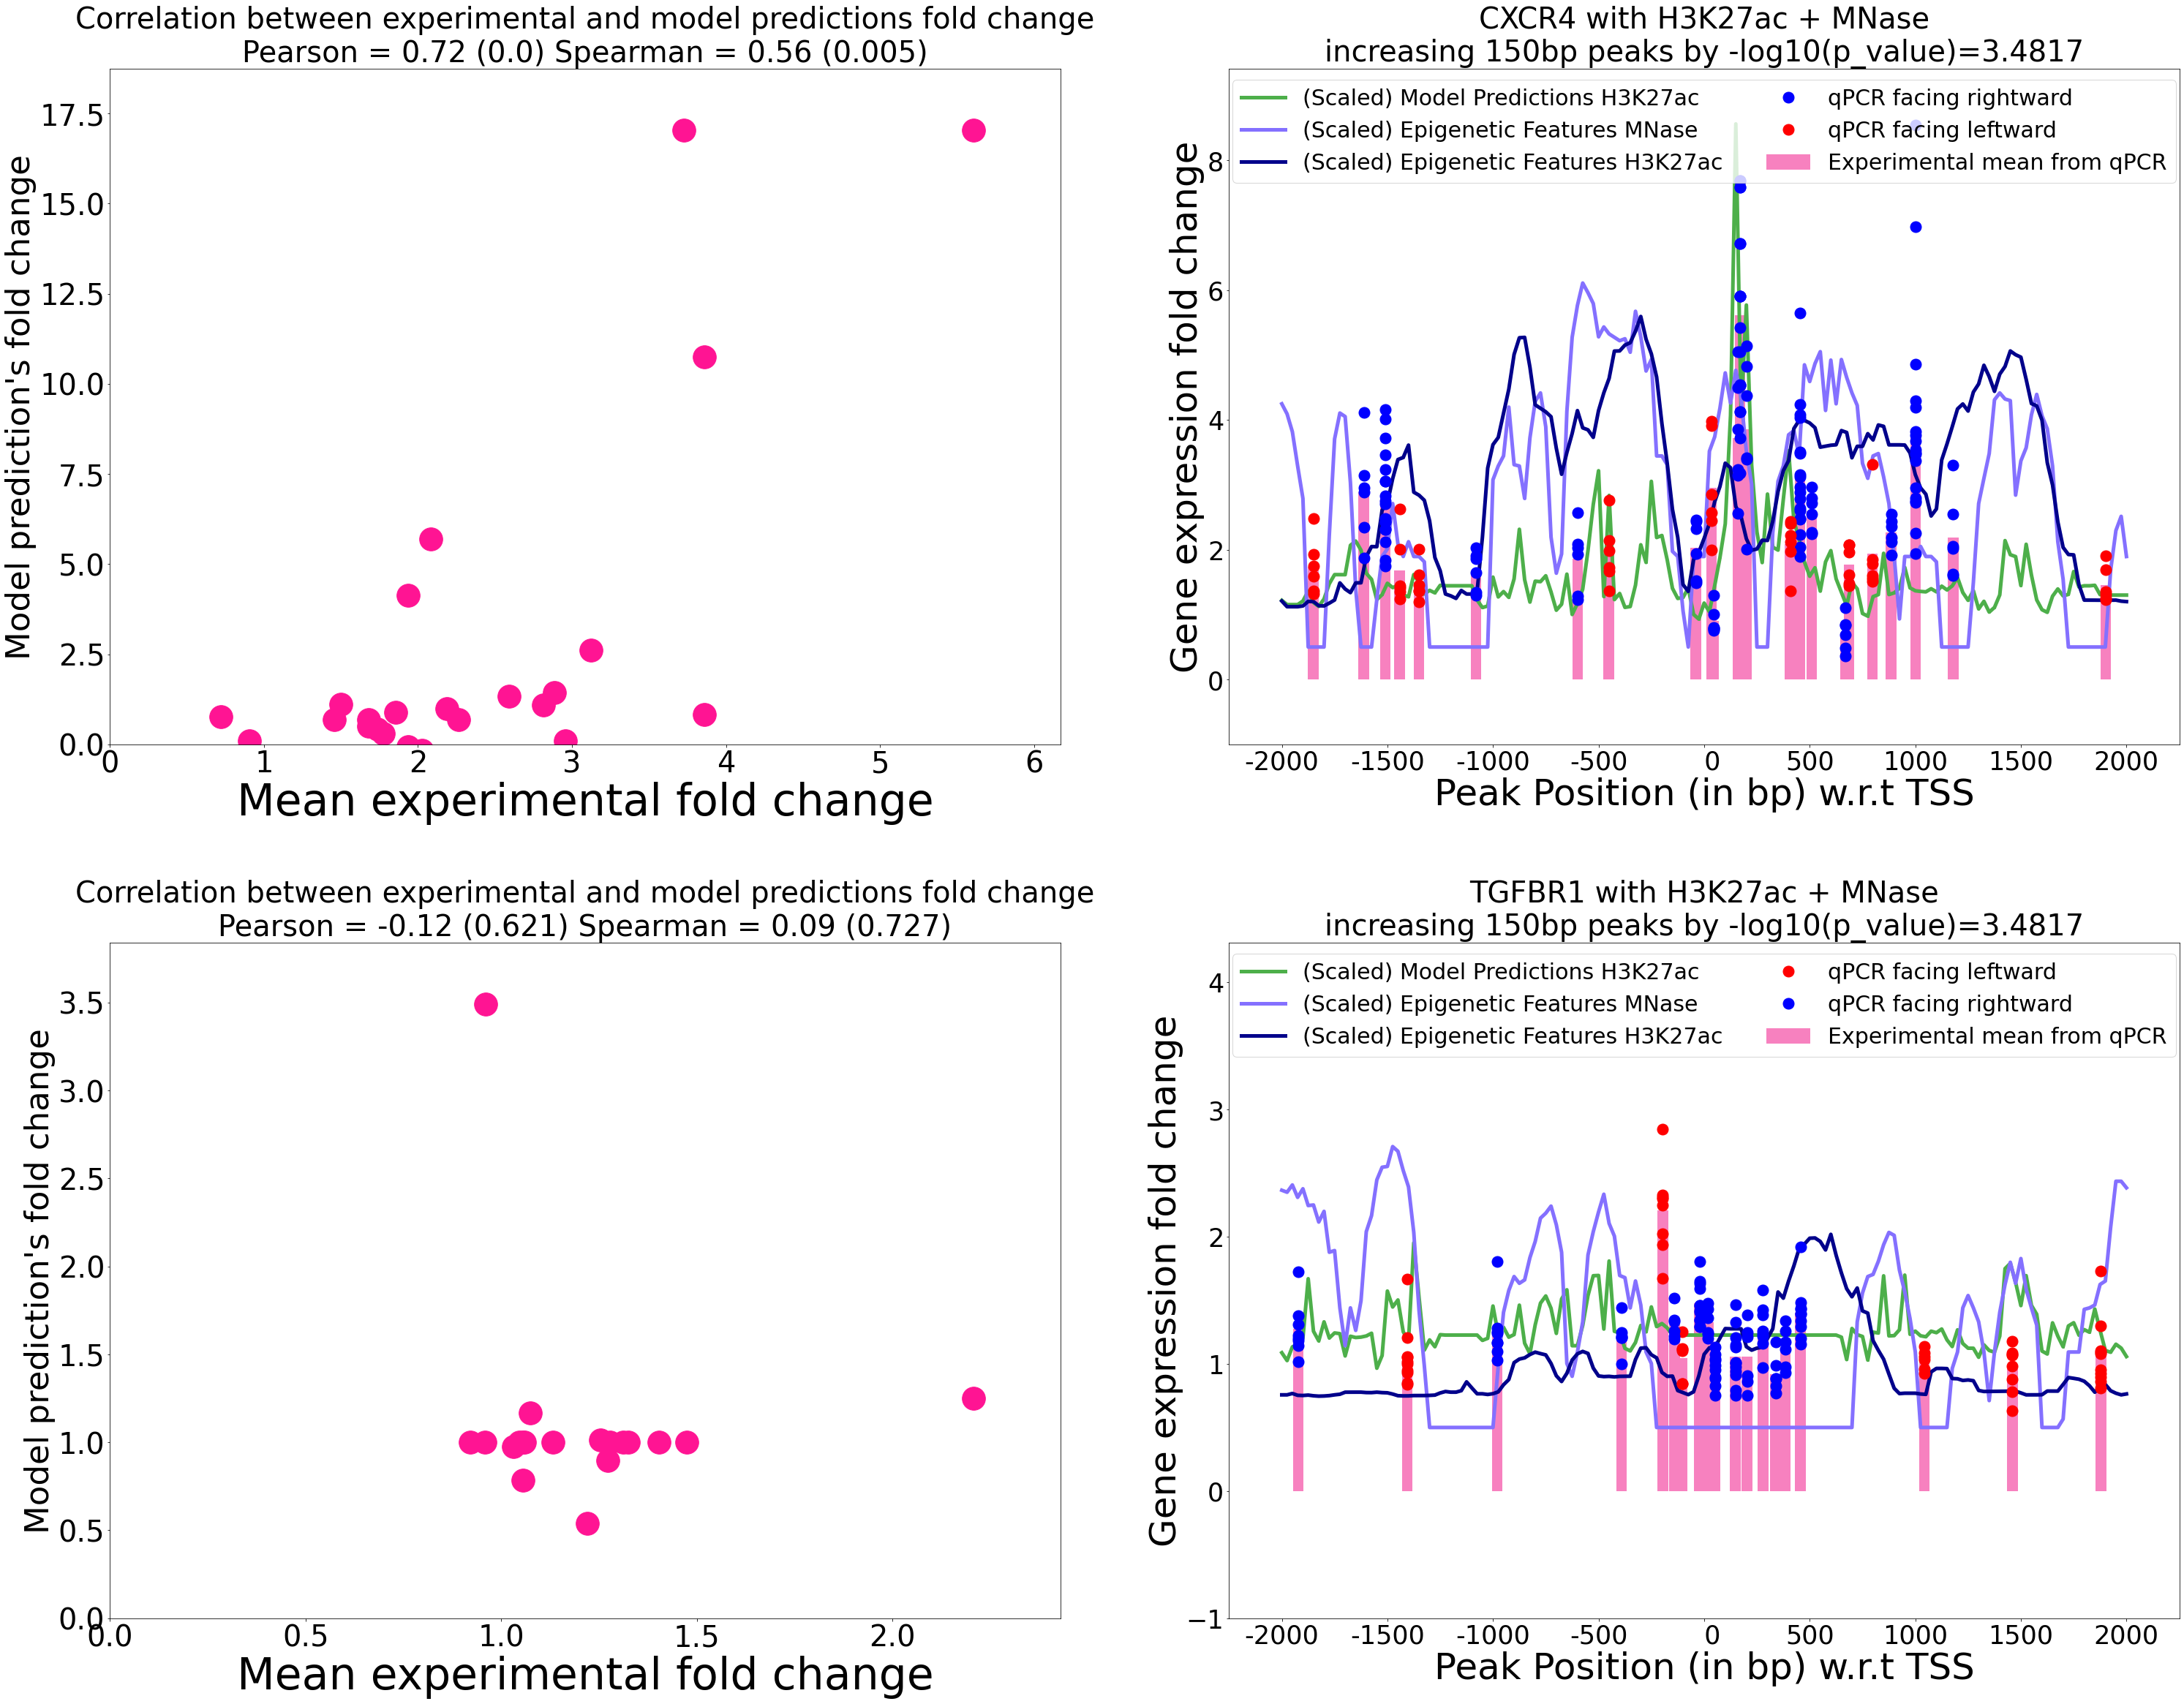

In [5]:
for TSS_methylation_lower_bound in [-1.0]:
#     for TSS_methylation_upper_bound in [6.0, 10000.0]:
    TSS_methylation_upper_bound = TSS_methylation_lower_bound + 70000
    for quantile_bound in [0.002]:
        if(TSS_methylation_lower_bound >= TSS_methylation_upper_bound):
            continue
        else:
            print(str(TSS_methylation_lower_bound), str(TSS_methylation_upper_bound))
        medium_methylation = [e[0] for e in methylation_level if ((e[1] >= TSS_methylation_lower_bound) & 
                                                                  (e[1] <= TSS_methylation_upper_bound))]

        df_H3K27ac_methylation = df_merged.iloc[medium_methylation, 
                                                np.r_[middle_position_first_feature-(operative_half_window_size):
                                                      middle_position_first_feature+(operative_half_window_size)+1, 
                                                      middle_position_second_feature-(operative_half_window_size):
                                                      middle_position_second_feature+(operative_half_window_size)+1,
                                                      window_size,
                                                      window_size + 1,
                                                      window_size + 2,
                                                      window_size + 3]]

        # print(df_H3K27ac_methylation)

        number_of_quantiles = 1
        quantiles = [-0.0001] # [df_H3K27ac_methylation["log10p1(TPM)_H3K27ac"].drop_duplicates().quantile(x) for x in np.arange(0, 1, 1.0/(number_of_quantiles*1.0))]
        quantiles.append(3)        
        print(quantiles)

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10), sharey=False)
        fig.tight_layout(pad=1, w_pad=5, h_pad=5)
        xticklabels = [RESOLUTION*x for x in range(-(operative_half_window_size), (operative_half_window_size)+1)]

        df_quantiles = {}
        for i in range(1, number_of_quantiles+1):
            df_quantiles[i] = df_H3K27ac_methylation[(df_H3K27ac_methylation["log10p1(TPM)_H3K27ac"] >= quantiles[i-1]) & (df_H3K27ac_methylation["log10p1(TPM)_H3K27ac"] < quantiles[i])]

            y_values = np.expm1(df_quantiles[i].iloc[:, 0 * (2 * operative_half_window_size + 1):1 * (2 * operative_half_window_size + 1)])
            y_corrected_values = y_values
            y_means = y_corrected_values.mean()
            y_stds = y_corrected_values.std()

            ax.plot(xticklabels, y_means, 
                     label=str(df_quantiles[i].shape[0])+" genes have TPM in ["+str(max(0.0, round(np.power(10, quantiles[i-1])-1,2)))+", "+
                            str(round(np.power(10, quantiles[i])-1,2))+")",
                            linewidth=5)

            ax.fill_between(xticklabels,
                            y_means-y_stds,
                            y_means+y_stds,
                            alpha=0.01)


#         # Compute H3K27ac tracks for CXCR4 and TGFBR1  
#         x = np.load("../Data/CXCR4.npy")
#         l = (x.shape[1])//2
#         CXCR4_DNase = x[0, l-operative_half_window_size:l+operative_half_window_size+1, 1-1]
#         CXCR4_H3K27ac = x[0, l-operative_half_window_size:l+operative_half_window_size+1, 4-1]

#         CXCR4_2 = x[0, l-operative_half_window_size:l+operative_half_window_size+1, 2-1]
#         CXCR4_3 = x[0, l-operative_half_window_size:l+operative_half_window_size+1, 3-1]
#         CXCR4_5 = x[0, l-operative_half_window_size:l+operative_half_window_size+1, 5-1]
#         CXCR4_6 = x[0, l-operative_half_window_size:l+operative_half_window_size+1, 6-1]
#         CXCR4_7 = x[0, l-operative_half_window_size:l+operative_half_window_size+1, 7-1]        

        
#         x = np.load("../Data/TGFBR1.npy")
#         l = (x.shape[1])//2
#         TGFBR1_DNase = x[0, l-operative_half_window_size:l+operative_half_window_size+1, 1-1]
#         TGFBR1_H3K27ac = x[0, l-operative_half_window_size:l+operative_half_window_size+1, 4-1]
        
#         TGFBR1_2 = x[0, l-operative_half_window_size:l+operative_half_window_size+1, 2-1]
#         TGFBR1_3 = x[0, l-operative_half_window_size:l+operative_half_window_size+1, 3-1]
#         TGFBR1_5 = x[0, l-operative_half_window_size:l+operative_half_window_size+1, 5-1]
#         TGFBR1_6 = x[0, l-operative_half_window_size:l+operative_half_window_size+1, 6-1]
#         TGFBR1_7 = x[0, l-operative_half_window_size:l+operative_half_window_size+1, 7-1]        

# #         ax.plot(xticklabels, np.expm1(CXCR4_DNase), color="blue", label="CXCR4_DNase", linewidth=5)
# #         ax.plot(xticklabels, np.expm1(CXCR4_H3K27ac), color="darkblue", label="CXCR4_H3K27ac", linewidth=5)
  
#         ax.plot(xticklabels, np.expm1(CXCR4_DNase), color="black", label="CXCR4_DNase", linewidth=5)
#         ax.plot(xticklabels, np.expm1(CXCR4_H3K27ac), color="blue", label="CXCR4_H3K27ac", linewidth=5)

#         ax.plot(xticklabels, np.expm1(CXCR4_2), color="green", label="CXCR4_2", linewidth=5)
#         ax.plot(xticklabels, np.expm1(CXCR4_3), color="pink", label="CXCR4_3", linewidth=5)
#         ax.plot(xticklabels, np.expm1(CXCR4_5), color="red", label="CXCR4_5", linewidth=5)
#         ax.plot(xticklabels, np.expm1(CXCR4_6), color="brown", label="CXCR4_6", linewidth=5)
#         ax.plot(xticklabels, np.expm1(CXCR4_7), color="purple", label="CXCR4_7", linewidth=5)
    
    
#         ax.plot(xticklabels, np.expm1(TGFBR1_DNase), color="black", label="TGFBR1_DNase", linewidth=5)
#         ax.plot(xticklabels, np.expm1(TGFBR1_H3K27ac), color="blue", label="TGFBR1_H3K27ac", linewidth=5)

#         ax.plot(xticklabels, np.expm1(TGFBR1_2), color="green", label="TGFBR1_2", linewidth=5)
#         ax.plot(xticklabels, np.expm1(TGFBR1_3), color="pink", label="TGFBR1_3", linewidth=5)
#         ax.plot(xticklabels, np.expm1(TGFBR1_5), color="red", label="TGFBR1_5", linewidth=5)
#         ax.plot(xticklabels, np.expm1(TGFBR1_6), color="brown", label="TGFBR1_6", linewidth=5)
#         ax.plot(xticklabels, np.expm1(TGFBR1_7), color="purple", label="TGFBR1_7", linewidth=5)


        # ax.set_title("Title", fontsize=25)

        ax.set_xlim(-3000, 3000)
        ax.set_ylim(0, 25)

        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.tick_params(axis='both', which='minor', labelsize=10)
        ax.set_xlabel("Position (in bp) w.r.t TSS", size=15)
        ax.set_ylabel("-log10(p-value)", size=15)

        ax.legend(loc='upper right', prop={'size': 30}, ncol=2)
        fig.suptitle("Metagene plot of H3K27ac for genes\nwith "+str(assays[assay_index_choice-1])+" level in ["+
                     str(TSS_methylation_lower_bound)+", "+
                     str(TSS_methylation_upper_bound)+"]", fontsize=60,  y=1.18)
        plt.show()

        # Choose assay for clustering epigenetic data and training models
        for quantile_index in range(1, number_of_quantiles+1):
            print("Quantile ", quantile_index)
            for inserted_pvalue_choice in [1.5]:
                peak_width_choice = {}
                peak_width_choice["CXCR4"] = 6
                peak_width_choice["TGFBR1"] = 6

                for assay_index in range(assay_index_choice, assay_index_choice+1):  # 1 through 9; this is the assay that's concatenated with H3K27ac in the input features

        #             # Take every ninth row to get a particular assay
        #             df_H3K27ac = df_sorted_unique.iloc[range(4-1, len(df_sorted_unique), len(assays)), :]
        #             df_other_assay = df_sorted_unique.iloc[range(assay_index-1, len(df_sorted_unique), len(assays)), :]
        #             df_merged = pd.merge(df_H3K27ac, df_other_assay, how='inner', on=['cell_type', 'chrom', 'position', 'strand'], suffixes=['_H3K27ac', '_'+assays[assay_index-1]])

        #             print(len(df_H3K27ac), len(df_other_assay), len(df_merged))

        #             # Only consider neighbors of the gene 
        #             distance_threshold = 100                    
        #             neighbors = [int(e[0]) for e in distances if (e[1] < distance_threshold)]
        #             print("Number of neighbors at distance_threshold = ", distance_threshold, "are = ", len(neighbors))
        #             df_neighbors = df_merged.iloc[neighbors, :]

        # #             Confirm that the distance subsetting is working!
        # #             distances_confirm = []
        # #             for i in tqdm(range(min(1000000, len(df_neighbors)))):
        # #                 distances_confirm.append((i, compute_distance(gene_feature, 
        # #                                                               df_neighbors.iloc[i, 
        # #                                                                                middle_position_second_feature-(window_size//2):middle_position_second_feature+(window_size//2)+1,])))

        # #             distances_confirm = np.asarray(distances_confirm)            
        # # #             print("Max distance encountered = ", max(distances_confirm[:, 1]), " with distance_threshold = ", distance_threshold)
        # #             plt.hist(distances_confirm[:, 1], bins=1000, color='pink')
        # #             plt.show()
        # #             assert(False)

        #             # Now obtain the relevant positions as features
        #             middle_position_first_feature = window_size // 2
        #             middle_position_second_feature = -1 + ( (window_size + 6) + (window_size + 6 + window_size + 1) )//2


        #             df_processed = df_neighbors.iloc[:, np.r_[middle_position_first_feature-operative_half_window_size:middle_position_first_feature+operative_half_window_size+1, 
        #                                                    middle_position_second_feature-operative_half_window_size:middle_position_second_feature+operative_half_window_size+1,
        #                                                    window_size,
        #                                                    window_size + 1,
        #                                                    window_size + 2,
        #                                                    window_size + 3]]

        #             df_sorted_by_TPM = df_processed  # df_processed.sort_values(['log10p1(TPM)_H3K27ac'], ascending=[1])
        #             print("Finished sorting by TPM")

        # #             kmeans_number_of_clusters = 1
        # #             binary_clustering = False
        # #             binary_threshold = {1:20, 2:0.8, 3:0.8, 4:5, 5:0.8, 6:50, 7:0.6, 8:0.7, 9:0.7}
        # #             # Cluster on assay (not H3K27ac always)
        # #             df_clustering = df_sorted_by_TPM
        # #             if(binary_clustering):
        # #                 for cidx in range(1 * (2*operative_half_window_size+1), 2 * (2*operative_half_window_size+1)):
        # #                     df_clustering.iloc[:, cidx] = (df_sorted_by_TPM.iloc[:, cidx] >= binary_threshold[assay_index]).astype(int)
        # #             kmeans_labels = cluster.KMeans(n_clusters=kmeans_number_of_clusters).fit_predict(df_clustering.iloc[:, 0 * (2 * operative_half_window_size + 1): 1 * (2 * operative_half_window_size + 1)])

        # #             CXCR4_index = -10 # kmeans_labels[df_sorted_by_TPM.index[(df_sorted_by_TPM['chrom'] == "chr2") & (df_sorted_by_TPM['position'] == 136118149)][0]]
        # #             TGFBR1_index = -10 # kmeans_labels[df_sorted_by_TPM.index[(df_sorted_by_TPM['chrom'] == "chr9") & (df_sorted_by_TPM['position'] == 99105113)][0]]
        # #             print("Finished K-Means clustering with "+str(kmeans_number_of_clusters)+" clusters")

                    # Create train-test split
                    if(pairwise_flag):
                        pairwise_multiplier = 0
                    else:
                        pairwise_multiplier = 1

                    results = []
                    special_gene_ise = []
                    special_alan_means = []

        #             # for peak_width_choice, inserted_pvalue_choice in list(itertools.product(peak_widths, pvalues)):

        # #             for kmeans_label in set(kmeans_labels): #[0.1]*5+[0.3]*5+[0.5]*5+[0.7]*5+[0.9]*5+[0.95]*5+[0.99]*5:
        # #                 print("K-Means Cluster = ", kmeans_label, " CXCR4 Cluster = ", CXCR4_index, " TGFBR1 Cluster = ", TGFBR1_index)
        # #                 df_subsampled = df_sorted_by_TPM.iloc[np.where(kmeans_labels==kmeans_label)[0], :]

                    for subsampling_fraction in [0.999]:
                        df_subsampled = df_quantiles[quantile_index] # df_sorted_by_TPM.sample(int(subsampling_fraction * len(df_sorted_by_TPM)), replace=False)

                    ######################################################################################
                    # for chromosome_choice in range(1, 21, 1):

                        # # Subsample rows but only in a radius of the log10p1(TPM) of interest  
                        # logTPM_of_interest = np.log10(12+1) # CXCR4 is 12 and TGFBR1 is 0.6
                        # num_rows = int(subsampling_fraction * len(df_sorted_by_TPM))
                        # for idx in range(1, len(df_sorted_by_TPM)):
                        #     if( (df_sorted_by_TPM["log10p1(TPM)_H3K27ac"][idx-1]>= logTPM_of_interest) & 
                        #         (df_sorted_by_TPM["log10p1(TPM)_H3K27ac"][idx] <= logTPM_of_interest) ):
                        #         break

                        # # Now subsample num_rows rows in the neighborhood of idx
                        # ld = len(df_sorted_by_TPM)
                        # if(idx + (num_rows//2) > ld):
                        #     start_idx = ld - num_rows
                        #     end_idx = ld
                        # elif(idx - (num_rows//2) < 0):
                        #     start_idx = 0
                        #     end_idx = num_rows
                        # else:
                        #     start_idx = idx - (num_rows//2)
                        #     end_idx = idx + (num_rows//2)

                        # df_subsampled = df_sorted_by_TPM.iloc[start_idx:end_idx, :]
                    ######################################################################################


                        odd_chroms = ["chr" + str(c) for c in range(1, 23, 1)]
                        odd_chroms.remove("chr2") # exclude chr2 where CXCR4 lies
                        odd_chroms.remove("chr9") # exclude chr2 where TGFBR1 lies
                        df_odd_chroms = df_subsampled.loc[df_subsampled['chrom'].isin(odd_chroms)]
                        xTrain = df_odd_chroms.iloc[:, pairwise_multiplier*(2 * operative_half_window_size + 1):2 * (2 * operative_half_window_size + 1)] 
                        yTrain = df_odd_chroms.iloc[:, 2 * (2 * operative_half_window_size + 1)]

                        even_chroms = ["chr" + str(c) for c in range(1, 23, 2)]
                        df_even_chroms = df_subsampled.loc[df_subsampled['chrom'].isin(even_chroms)]
                        xTest = df_even_chroms.iloc[:, pairwise_multiplier*(2 * operative_half_window_size + 1):2 * (2 * operative_half_window_size + 1)] 
                        yTest = df_even_chroms.iloc[:, 2 * (2 * operative_half_window_size + 1)]

                        if(len(xTrain) < 10):
                            print("len(xTrain) = "+str(len(xTrain)))
                            continue

                        quadratic_transform = PolynomialFeatures(degree=1, interaction_only=True).fit(xTrain)
                        xTrain = quadratic_transform.transform(xTrain)
                        xTest = quadratic_transform.transform(xTest)

                        # xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.30, random_state=42)
                        print(xTrain.shape, xTest.shape, yTrain.shape, yTest.shape)

                        # Fit a model
#                         model = linear_model.LinearRegression(normalize=False) # doesn't seem to matter whether True or False

                        l1_alpha = 0.001
                        model = linear_model.ElasticNet(alpha=l1_alpha, l1_ratio=0.0, max_iter=1000)

                #         model = RandomForestRegressor(verbose=0, n_estimators=50, n_jobs=8)

                        '''
                        model = MLPRegressor(hidden_layer_sizes=(100, 100, 100), 
                                             alpha=0.0000000001,
                                             batch_size=128,
                                             activation='relu', # logistic and relu tend to have few features active 
                                             max_iter=1000,
                                             solver='adam', 
                                             tol=0.000001,
                                             verbose=0)
                         '''

                        xTrain = np.asarray(xTrain)
                        yTrain = np.asarray(yTrain)
                        xTest = np.asarray(xTest)
                        yTest = np.asarray(yTest)

                        model.fit(xTrain, yTrain)

                        # Compute statistics
                        yTrain_Pred = model.predict(xTrain)
                        yTest_Pred = model.predict(xTest)
                        mse_Train = mean_squared_error(yTrain, yTrain_Pred)
                        pc_Train, _ = pearsonr(yTrain, yTrain_Pred)
                        sc_Train, _ = spearmanr(yTrain, yTrain_Pred)
                        mse_Test = mean_squared_error(yTest, yTest_Pred)
                        pc_Test, _ = pearsonr(yTest, yTest_Pred)
                        sc_Test, _ = spearmanr(yTest, yTest_Pred)

                        print("Train: MSE = ", round(mse_Train, 3), "Pearson =", round(pc_Train, 3), "Spearman =", round(sc_Train, 3))
                        print("Test: MSE = ", round(mse_Test, 3), "Pearson =", round(pc_Test, 3), "Spearman =", round(sc_Test, 3))

                        # Visualize the model's predictions
                #         plt.rcParams["figure.figsize"] = (20, 12)
                #         plt.plot(yTest, yTest_Pred, 'o', markersize=3, color='#EE7AE9')
                #         plt.xlabel("True Normalized TPM", size=40)
                #         plt.ylabel("Predicted Normalized TPM", size=40)
                #         plt.xlim(-0.5, 4)
                #         plt.ylim(-0.5, 2)
                #         plt.title("#points = "+str(len(yTest))+"\nPearson = "+str(round(pc_Test, 3))+" Spearman = "+str(round(sc_Test, 3)), size=50)
                #         plt.show()

                        # Model feature importances
                    #     plt.plot(model.loss_curve_)
                    #     plt.plot([model.intercept_] + model.coef_[:2*operative_half_window_size+1], 'o')
                        # plt.plot(model.feature_importances_)
                        # plt.show()

                        # explainer = shap.TreeExplainer(model)
                        # shap_values = explainer.shap_values(xTrain.iloc[:10, :])
                        # shap.summary_plot(shap_values, xTrain.iloc[:10, :])
                        # shap.plots.beeswarm(shap_values, xTest.iloc[:10, :])


                        # Perform inference for epigenome editing data
                        def ise(gene, trained_model, assay_index, inserted_lnp1_minuslog10p_value = 3, peak_width = 2, pairwise_features=False):

                            X = np.load("../Data/" + gene + ".npy")

                            # obtain the middle portion of this
                            X = X[:, (window_size//2)-operative_half_window_size:(window_size//2)+operative_half_window_size+1, :]

                            # Perform inference by introducing p-value changes with a peak width
                            yPred = []
                            center = operative_half_window_size
                            positions = range(center - center, center + center + 1)
                            for pos in positions:
                                X_modified = np.copy(X)
                                for p in range(pos - peak_width // 2, pos + peak_width // 2 + 1):
                                    if( (p>=0) and (p < max(positions)) ):
                                        if(X_modified[:, p, 2] > 10): # Remember this is ln( -log10(p-value) + 1)
                                            # If H3K27me3 peak exists, then p300 doesn't work
                                            print("H3K27me3 exists!")
                                            pass
                                        else:
                                            if (pairwise_features):
                                                # Modify the H3K27ac peak                                                
                                                X_modified[:, p, 3] = X_modified[:, p, 3] + (X_modified[:, p, 9] * inserted_lnp1_minuslog10p_value)
                                            else:
                                                # Modify the assay itself
                                                X_modified[:, p, assay_index] += inserted_lnp1_minuslog10p_value

                                # Prepare input
                                if (pairwise_features):
                                    X_modified = np.concatenate([X_modified[:, :, 3], X_modified[:, :, assay_index]], axis=1)
                                else:                 
                                    X_modified = X_modified[:, :, assay_index]

                                yPred_value = trained_model.predict(quadratic_transform.transform(X_modified))
                                yy = yPred_value[0]
                                yPred.append(yy)

                            # Prepare input for predicting native expression
                            if(pairwise_features):
                                X = np.concatenate([X[:, :, 3], X[:, :, assay_index]], axis=1) 
                            else:
                                X = X[:, :, assay_index]

                            # Instead of scaling, divide by yPred
                            yPred_value = trained_model.predict(quadratic_transform.transform(X))[0] + 0.00000001 # to avoid divby0
                            print("Predicted TPM for ", gene, " = ", (np.power(10, yPred_value) -1))
                            yPred = (np.power(10, yPred) -1) / (np.power(10, yPred_value) -1)

                            return yPred


                        def p_value_mapping(inserted_lnp1_minuslog10p_value):
                            minuslog10p_value = np.expm1(inserted_lnp1_minuslog10p_value)
                            p_value = np.power(10, -1 * minuslog10p_value)
                            return round(minuslog10p_value, 4)


                        def convert_to_2D(idx, nrows, ncols):
                            return idx//ncols, idx%ncols


                        # Load p300 epigenome editing data
                        df_p300_epigenome_editing = pd.read_csv("../Data/p300_epigenome_editing_dataset.tsv", sep="\t")

                        TSS = {}
                        STRANDS = {}
                        CHROMS = {}
                        GENES = {}
                        gRNA_STRANDS = {}
                        for index in range(len(df_p300_epigenome_editing)):
                            tss = df_p300_epigenome_editing.iloc[index, 13]
                            gene_strand = df_p300_epigenome_editing.iloc[index, 3]
                            chrom = df_p300_epigenome_editing.iloc[index, 2]
                            gene = df_p300_epigenome_editing.iloc[index, 0]
                                                        
                            TSS[gene] = int(tss)

                            if(gene_strand == "plus"):
                                STRANDS[gene] = "+"
                            elif(gene_strand == "minus"):
                                STRANDS[gene] = "-"
                            else:
                                print("something wrong with strand!")

                            CHROMS[gene] = chrom
                            GENES[gene] = 1                                                    
                            
                        GENES_LIST = set(list(GENES.keys()))    

                        df_GENES_values = {}
                        df_GENES_means = {}
                        for gene in GENES_LIST:
                            df_GENES_values[gene] = df_p300_epigenome_editing[df_p300_epigenome_editing["p300 target gene"] == gene]
                            df_GENES_values[gene]["Position_wrt_TSS"] = pd.to_numeric(df_GENES_values[gene]["gRNA position  wrt TSS (hg38)"], errors='coerce')/RESOLUTION
                            df_GENES_values[gene]["gRNA_strand"] = df_GENES_values[gene]["gRNA target strand"].apply(lambda s: "red" if(s=="minus") else "blue")
                            df_GENES_values[gene]["gRNA_strand_bool"] = df_GENES_values[gene]["gRNA target strand"].apply(lambda s: -1 if(s=="minus") else +1)

                            df_GENES_means[gene] = df_GENES_values[gene].groupby('Position_wrt_TSS').mean()
                            df_GENES_means[gene].index.name = 'Position_wrt_TSS'
                            df_GENES_means[gene].reset_index(inplace=True)

                        # Perform in-silico epigenesis
                        assay_color = ['black', 'red', 'green', 'blue', 'cyan', 'pink', 'brown']
                        xticklabels = range(-operative_half_window_size, operative_half_window_size + 1)

                        GENES_LIST = ["CXCR4", "TGFBR1"]

                        fig, axes = plt.subplots(nrows=len(GENES_LIST), ncols=2, figsize=(40, 30), sharey=False)
                        fig.tight_layout(pad=1, w_pad=20, h_pad=25)

                        for idx, gene in enumerate(sorted(GENES_LIST)):

                            idx_x, idx_y = convert_to_2D(idx, nrows=len(GENES_LIST), ncols=1)
                            ax_1 = axes[idx_x, 0]
                            ax_2 = axes[idx_x, 1]

                            gene_features = np.squeeze(np.load("../Data/" + gene + ".npy"), axis=0)
                            gene_features = gene_features[(window_size//2)-operative_half_window_size:(window_size//2)+operative_half_window_size+1, :]


                            '''
                            plt.rcParams["figure.figsize"] = (20, 10)

                            plt.figure(0)
                            ax = sns.heatmap(np.transpose(gene_features), annot=False, fmt="f",
                                             vmin=0.0, vmax=2.0,
                                             yticklabels=assays, xticklabels=xticklabels)
                            plt.show()
                            plt.close()
                            '''

                            df_values = df_GENES_values[gene]
                            df_means = df_GENES_means[gene]
#                             print(list(df_values["gRNA_strand"]))

                            inserted_lnp1_minuslog10p_value = inserted_pvalue_choice
                            peak_width = peak_width_choice[gene]
                            gene_ise = ise(gene, model, assay_index-1, inserted_lnp1_minuslog10p_value, peak_width, pairwise_flag)

                            # Create a scatter plot of the means with the predictions of those positions
                            gene_ise_at_means = []
                            alan_means = []
                            gRNA_strands = []
#                             print(df_means)
                            for p_idx in range(len(df_means)):
                                position_m = df_means.iloc[p_idx, 0]
                                alan_mean = df_means.iloc[p_idx, 1]
                                gRNA_strand = df_means.iloc[p_idx, 9]
                                if(position_m + operative_half_window_size < 0):
                                    continue
                                elif(position_m > operative_half_window_size):
                                    continue
                                else:
                                    gene_ise_at_means.append(gene_ise[int(position_m) + operative_half_window_size])
                                    alan_means.append(alan_mean)
                                    gRNA_strands.append(gRNA_strand)

                            pc, pp = pearsonr(list(alan_means), gene_ise_at_means)
                            sc, sp = spearmanr(list(alan_means), gene_ise_at_means)

                        #         print(peak_width_choice, inserted_pvalue_choice, gene, pc, sc)
                        #         results.append([peak_width_choice, inserted_pvalue_choice, gene, pc, sc])
                            gRNA_strands_colors = []
                            for iii in gRNA_strands:
                                if(iii == -1):
                                    gRNA_strands_colors.append("red")
                                else:
                                    gRNA_strands_colors.append("blue")

                            ax_1.scatter(list(alan_means), gene_ise_at_means, color="#FF1493", s=1000) # ="#FF1493")
                            ax_1.set_xlim(0, 1.1 * max(alan_means))
                            ax_1.set_ylim(0, 1.1 * max(gene_ise_at_means))
                            ax_1.tick_params(axis='both', which='major', labelsize=40)
                            ax_1.tick_params(axis='both', which='minor', labelsize=40)
                            ax_1.set_xlabel("Mean experimental fold change", size=60)
                            ax_1.set_ylabel("Model prediction's fold change", size=45)
                        #     if(pp > 0.05):
                        #         p_asterisk = "NS"
                        #     if(sp > 0.05):
                        #         s_asterisk = "NS"
                            ax_1.set_title("Correlation between experimental and model predictions fold change\nPearson = "+
                                           str(round(pc, 2))+
                                           " ("+str(round(pp, 3))+
                                           ") Spearman = "+
                                           str(round(sc, 2))+
                                           " ("+str(round(sp, 3))+
                                           ")", size=40)

                            # Determine whether we are doing H3K27ac ISE in the background of another assay's features
                            # or we have marginal features and are doing that track's ISE
                            if(pairwise_flag):
                                epigenetic_features = gene_features[:, 9] # MNase
                                epigenetic_features_2 = gene_features[:, 3] # H3K27ac
                                color_for_assay = assay_color[3]
                                label_for_assay = assays[3]
                            else:
                                epigenetic_features = gene_features[:, assay_index-1]
                                color_for_assay = assay_color[assay_index-1]
                                label_for_assay = assays[assay_index-1]

                            # Scale the model predictions     
                            scaling_ratio = np.median(df_means['Measured fold change'])/np.median(gene_ise - 0.0)
                            scaled_model_predictions = 0.2 * (scaling_ratio * (gene_ise - 0.0)) + 1.0

                            # Scale the epigenetic features
                            epigenetic_features_scaling_ratio = max(df_means['Measured fold change'])/max(epigenetic_features - 0.0)
                            scaled_epigenetic_features = (epigenetic_features_scaling_ratio * (epigenetic_features - 0.0)) + 0.5

                            scaled_epigenetic_features_2 = (epigenetic_features_scaling_ratio * (epigenetic_features_2 - 0.0)) + 0.5 
                            
                            ax_2.plot(xticklabels, scaled_model_predictions, 'o-', color="#4daf4a", linewidth=5, markersize=2, label="(Scaled) Model Predictions " + label_for_assay)
                            ax_2.plot(xticklabels, scaled_epigenetic_features, 'o-', color="#8470FF", linewidth=5, markersize=1, label="(Scaled) Epigenetic Features MNase") # + label_for_assay)
                            ax_2.plot(xticklabels, scaled_epigenetic_features_2, 'o-', color="darkblue", linewidth=5, markersize=1, label="(Scaled) Epigenetic Features H3K27ac") # + label_for_assay)

                            ax_2.bar(df_means['Position_wrt_TSS'], 0.0 + (df_means['Measured fold change']), color="#f781bf", bottom=0, width=2, label="Experimental mean from qPCR")

                            gRNA_strand_groups = df_values.groupby("gRNA target strand")
                            
                            color_dict = {}
                            color_dict["+"] = {"plus":"blue", "minus":"red"}
                            color_dict["-"] = {"plus":"red", "minus":"blue"}
                            direction = {"blue":"rightward", "red":"leftward"}
                            color_index = 0
                            for name, group in gRNA_strand_groups:
                                ax_2.plot(group['Position_wrt_TSS'], 0.0 + (group['Measured fold change']), 'o', color=color_dict[STRANDS[gene]][name], label="qPCR facing "+direction[color_dict[STRANDS[gene]][name]], markersize=15)
                                color_index += 1
                                
                            ax_2.set_xlim(-operative_half_window_size-10, operative_half_window_size+10)
                            ax_2.set_ylim(-1, 1.0 + max(df_means['Measured fold change'])*1.5)
                            x_vals = ax_2.get_xticks()
                            ax_2.set_xticklabels(['{:3.0f}'.format(x * RESOLUTION) for x in x_vals])
                            ax_2.yaxis.set_major_locator(MaxNLocator(integer=True))
                            ax_2.tick_params(axis='both', which='major', labelsize=35)
                            ax_2.tick_params(axis='both', which='minor', labelsize=35)
                            ax_2.set_xlabel("Peak Position (in bp) w.r.t TSS", size=50)
                            ax_2.set_ylabel("Gene expression fold change", size=50)
                            ax_2.set_title(gene+" with H3K27ac + "+assays[assay_index-1]+"\nincreasing " + str(peak_width * RESOLUTION) + "bp peaks by -log10(p_value)="+str(p_value_mapping(inserted_lnp1_minuslog10p_value)), size=40) #, y=1.1)

                            ax_2.legend(loc='upper center', prop={'size': 30}, ncol=2)

                        plt.show()
                        plt.close()


In [ ]:
def ise(original_gene_features, trained_model, assay_index, inserted_lnp1_minuslog10p_value = 3, peak_width = 2, pairwise_features=False):

    # obtain the middle portion of this
    X = original_gene_features[:, (window_size//2)-operative_half_window_size:(window_size//2)+operative_half_window_size+1, :]

    # Perform inference by introducing p-value changes with a peak width
    yPred = []
    center = operative_half_window_size
    positions = range(center - center, center + center + 1)
    for pos in positions:
        X_modified = np.copy(X)
        for p in range(pos - peak_width // 2, pos + peak_width // 2 + 1):
            if( (p>=0) and (p < max(positions)) ):
                if(X_modified[:, p, 2] > 10): # Remember this is ln( -log10(p-value) + 1)
                    # If H3K27me3 peak exists, then p300 doesn't work
                    print("H3K27me3 exists!")
                    pass
                else:
                    if (pairwise_features):
                        # Modify the H3K27ac peak
                        X_modified[:, p, 3] = max(X_modified[:, p, 3], inserted_lnp1_minuslog10p_value)
                    else:
                        # Modify the assay itself
                        X_modified[:, p, assay_index] += inserted_lnp1_minuslog10p_value

        # Prepare input
        if (pairwise_features):
            X_modified = np.concatenate([X_modified[:, :, 3], X_modified[:, :, assay_index]], axis=1)
        else:                 
            X_modified = X_modified[:, :, assay_index]

        yPred_value = trained_model.predict(quadratic_transform.transform(X_modified))
        yy = yPred_value[0]
        yPred.append(yy)

    # Prepare input for predicting native expression
    if(pairwise_features):
        X = np.concatenate([X[:, :, 3], X[:, :, assay_index]], axis=1) 
    else:
        X = X[:, :, assay_index]

    # Instead of scaling, divide by yPred
    yPred_value = trained_model.predict(quadratic_transform.transform(X))[0] + 0.00000001 # to avoid divby0
    yPred = (np.power(10, yPred) -1) / (np.power(10, yPred_value) -1)

    return yPred


def p_value_mapping(inserted_lnp1_minuslog10p_value):
    minuslog10p_value = np.expm1(inserted_lnp1_minuslog10p_value)
    p_value = np.power(10, -1 * minuslog10p_value)
    return round(minuslog10p_value, 4)


def convert_to_2D(idx, nrows, ncols):
    return idx//ncols, idx%ncols

def validate_model(trained_model):

    # Load p300 epigenome editing data
    df_p300_epigenome_editing = pd.read_csv("../Data/p300_epigenome_editing_dataset.tsv", sep="\t")

    TSS = {}
    STRANDS = {}
    CHROMS = {}
    GENES = {}
    for index in range(len(df_p300_epigenome_editing)):
        tss = df_p300_epigenome_editing.iloc[index, 13]
        gene_strand = df_p300_epigenome_editing.iloc[index, 3]
        chrom = df_p300_epigenome_editing.iloc[index, 2]
        gene = df_p300_epigenome_editing.iloc[index, 0]

        TSS[gene] = int(tss)
        if(gene_strand == "plus"):
            STRANDS[gene] = "+"
        elif(gene_strand == "minus"):
            STRANDS[gene] = "-"
        else:
            print("something wrong with strand!")
        CHROMS[gene] = chrom
        GENES[gene] = 1

    GENES_LIST = set(list(GENES.keys()))    

    df_GENES_values = {}
    df_GENES_means = {}
    for gene in GENES_LIST:
        df_GENES_values[gene] = df_p300_epigenome_editing[df_p300_epigenome_editing["p300 target gene"] == gene]
        df_GENES_values[gene]["Position_wrt_TSS"] = pd.to_numeric(df_GENES_values[gene]["gRNA position  wrt TSS (hg38)"], errors='coerce')/RESOLUTION

        df_GENES_means[gene] = df_GENES_values[gene].groupby('Position_wrt_TSS').mean()
        df_GENES_means[gene].index.name = 'Position_wrt_TSS'
        df_GENES_means[gene].reset_index(inplace=True)

    # Perform in-silico epi-mutagenesis
    assay_color = ['black', 'red', 'green', 'blue', 'cyan', 'pink', 'brown']
    xticklabels = range(-operative_half_window_size, operative_half_window_size + 1)

    GENES_LIST = ["CXCR4", "TGFBR1"]

    fig, axes = plt.subplots(nrows=len(GENES_LIST), ncols=2, figsize=(40, 30), sharey=False)
    fig.tight_layout(pad=1, w_pad=20, h_pad=25)

    for idx, gene in enumerate(sorted(GENES_LIST)):

        idx_x, idx_y = convert_to_2D(idx, nrows=len(GENES_LIST), ncols=1)
        ax_1 = axes[idx_x, 0]
        ax_2 = axes[idx_x, 1]

        original_gene_features = np.load("../Data/" + gene + ".npy")
        gene_features = np.squeeze(original_gene_features, axis=0)[(window_size//2)-operative_half_window_size:(window_size//2)+operative_half_window_size+1, :]

        df_values = df_GENES_values[gene]
        df_means = df_GENES_means[gene]

        inserted_lnp1_minuslog10p_value = inserted_pvalue_choice
        peak_width = peak_width_choice[gene]
        gene_ise = ise(original_gene_features, trained_model, assay_index-1, inserted_lnp1_minuslog10p_value, peak_width, pairwise_flag)

        # Create a scatter plot of the means with the predictions of those positions
        gene_ise_at_means = []
        alan_means = []
        for p_idx in range(len(df_means)):
            position_m = df_means.iloc[p_idx, 0]
            alan_mean = df_means.iloc[p_idx, 1]
            if(position_m + operative_half_window_size < 0):
                continue
            elif(position_m > operative_half_window_size):
                continue
            else:
                gene_ise_at_means.append(gene_ise[int(position_m) + operative_half_window_size])
                alan_means.append(alan_mean)

        pc, pp = pearsonr(list(alan_means), gene_ise_at_means)
        sc, sp = spearmanr(list(alan_means), gene_ise_at_means)

        ax_1.plot(list(alan_means), gene_ise_at_means, 'o', markersize=30, color="#FF1493")
        ax_1.set_xlim(-1, 1.1 * max(alan_means))
        ax_1.set_ylim(-1, 1.1 * max(gene_ise_at_means))
        ax_1.tick_params(axis='both', which='major', labelsize=40)
        ax_1.tick_params(axis='both', which='minor', labelsize=40)
        ax_1.set_xlabel("Mean experimental fold change", size=60)
        ax_1.set_ylabel("Model prediction's fold change", size=45)
        ax_1.set_title("Correlation between experimental and model predictions fold change\nPearson = "+
                       str(round(pc, 2))+
                       " ("+str(round(pp, 3))+
                       ") Spearman = "+
                       str(round(sc, 2))+
                       " ("+str(round(sp, 3))+
                       ")", size=40)

        # Determine whether we are doing H3K27ac ISE in the background of another assay's features
        # or we have marginal features and are doing that track's ISE
        if(pairwise_flag):
            epigenetic_features = gene_features[:, 3] # H3K27ac
            color_for_assay = assay_color[3]
            label_for_assay = assays[3]
        else:
            epigenetic_features = gene_features[:, assay_index-1]
            color_for_assay = assay_color[assay_index-1]
            label_for_assay = assays[assay_index-1]

        # Scale the model predictions     
        scaling_ratio = np.median(df_means['Measured fold change'])/np.median(gene_ise - 0.0)
        scaled_model_predictions = (scaling_ratio * (gene_ise - 0.0)) + 0.0

        # Scale the epigenetic features
        epigenetic_features_scaling_ratio = max(df_means['Measured fold change'])/max(epigenetic_features - 0.0)
        scaled_epigenetic_features = (epigenetic_features_scaling_ratio * (epigenetic_features - 0.0)) + 0.5

        ax_2.plot(xticklabels, scaled_model_predictions, 'o-', color="#4daf4a", linewidth=5, markersize=2, label="(Scaled) Model Predictions " + label_for_assay)
        ax_2.plot(xticklabels, scaled_epigenetic_features, 'o-', color="#8470FF", linewidth=5, markersize=1, label="(Scaled) Epigenetic Features " + label_for_assay)

        ax_2.bar(df_means['Position_wrt_TSS'], 0.0 + (df_means['Measured fold change']), color="#f781bf", bottom=0, width=2, label="Experimental mean from qPCR")
        ax_2.plot(df_values['Position_wrt_TSS'], 0.0 + (df_values['Measured fold change']), 'o', color="#e41a1c", label="Experimental data from qPCR", markersize=10)

        ax_2.set_xlim(-operative_half_window_size-10, operative_half_window_size+10)
        ax_2.set_ylim(-1, 1.0 + max(df_means['Measured fold change'])*1.5)
        x_vals = ax_2.get_xticks()
        ax_2.set_xticklabels(['{:3.0f}'.format(x * RESOLUTION) for x in x_vals])
        ax_2.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax_2.tick_params(axis='both', which='major', labelsize=35)
        ax_2.tick_params(axis='both', which='minor', labelsize=35)
        ax_2.set_xlabel("Peak Position (in bp) w.r.t TSS", size=50)
        ax_2.set_ylabel("Gene expression fold change", size=50)
        ax_2.set_title(gene+" with H3K27ac + "+assays[assay_index-1]+"\nincreasing " + str(peak_width * RESOLUTION) + "bp peaks by -log10(p_value)="+str(p_value_mapping(inserted_lnp1_minuslog10p_value)), size=40) #, y=1.1)

        ax_2.legend(loc='upper center', prop={'size': 30}, ncol=2)

    plt.show()
    plt.close()
    
validate_model(model)    


In [ ]:
# Distribution of distances of other genes from CXCR4 and TGFBR1
'''
# Read in input features of CXCR4 and TGFBR1 in T13 for window_size = 401
colnames_special = ["pos_" + str(x) for x in list(range(-(window_size//2), (window_size//2) + 1))]
colnames_special = colnames_special + ["log10p1(TPM)", "cell_type", "chrom", "position", "strand", "assay_index"] 
df_special = pd.read_csv("../Data/CXCR4.TGFBR1.401.tsv", sep="\t", names=colnames_special)

df_special
'''

# Visualize behaviour of Methylation_pos and Methylation_neg
# 1. What do the epigenetic tracks for CXCR4 and TGFBR1 look like?
# 2. What is the distribution of distances of other genes from these genes
x = np.load("../Data/CXCR4.npy")
# plt.rcParams["figure.figsize"] = (20, 10)
# plt.plot(x[0, :, 3])
# plt.show()
assay_index_choice = 6 # 1 through 9
gene_feature = x[0, :, (assay_index_choice-1)]
CXCR4_H3K27ac = x[0, :, 4-1]

df_assay = df_sorted_unique.iloc[range(assay_index_choice-1, len(df_sorted_unique), len(assays)), :]

def compute_distance(u, v):
    l = len(u) // 2
    return np.linalg.norm(u[:l]-v[:l], ord=1)

distances = []
for i in tqdm(range(min(1000000, len(df_assay)))):
    distances.append((i, compute_distance(gene_feature, df_assay.iloc[i, :window_size])))
    
distances = np.asarray(distances)
plt.hist(distances[:, 1], bins=1000, color='pink')
plt.show()

# 2. What does the distribution of methylation levels within +-100bp of the TSS look like across gene expression?
# Can we precompute the chrom, pos, strand tuples for each methylation quantile to be used for H3K27ac metagene plots?


In [ ]:
# What is the dependence of the correlation between experimental and model predictions fold change on:
# a) peak width
# b) inserted p-value

# a) peak width

pc_list = [0.33, 0.31, -0.14, -0.15, 0.65, 0.65, 0.28, 0.26, 0.24, 0.23]
sc_list = [0.1, 0.09, -0.11, -0.09, 0.54, 0.54, 0.44, 0.44, 0.18, 0.16]

plt.rcParams["figure.figsize"] = (40, 20)
plt.plot(np.arange(50, 276, 25), pc_list, 'o-', label="Pearson R", linewidth=10, markersize=20, color="#4daf4a")
plt.plot(np.arange(50, 276, 25), sc_list, 'o-', label="Spearman R", linewidth=10, markersize=20, color="#EE7AE9")
plt.xlabel("Inserted peak width", size=60)
plt.ylabel("Correlation", size=60)
plt.xlim(40, 300)
plt.ylim(-0.5, 1)
plt.tick_params(axis='both', which='major', labelsize=40)
plt.tick_params(axis='both', which='minor', labelsize=40)
plt.title("Correlation between experimental and model predictions' fold change\nfor CXCR4, as a function of inserted peak width", size=60)
plt.legend(loc='upper center', prop={'size': 60}, ncol=2)
plt.show()
plt.close()



In [ ]:
# Metagene plots of epigenetic tracks for gene expression quantiles
plt.rcParams["figure.figsize"] = (80, 20)
xticklabels = [RESOLUTION*x for x in range(-(window_size//2), (window_size//2)+1)]

Avocado_list = ["T11_A04", "T12_A07", "T08_A01", "T09_A01", "T10_A01", "T11_A01", "T12_A01", "T13_A03"]

# Step-0: Subset dataframe to cell type and assay type
# cell_types = ["T{0:0=2d}".format(x) for x in [1,2,3,4,5,6,7,8,9,10,11,13]]
# cell_types = ["T01", "T09", "T01", "T09"]
cell_types = ["T13"] # "T01", "T02", "T05", "T06", "T13", "T13"]

cell_type_names = {'T01':'IMR-90', 
                   'T02':'H1-hESC', 
                   'T03':'trophoblast_cell', 
                   'T04':'neural_stem_progenitor_cell', 
                   'T05':'K562', 
                   'T06':'heart_left_ventricle',
                   'T07':'adrenal_gland',
                   'T08':'endocrine_pancreas',
                   'T09':'peripheral_blood_mononuclear_cell',
                   'T10':'amnion',
                   'T11':'myoepithelial_cell_of_mammary_gland',
                   'T12':'chorion',
                   'T13':'HEK293*'}

assay_type_ylim = {1:100, 2:2.5, 3:2, 4:20, 5:2, 6:150, 7:0.7, 8:2, 9:2, 10:6}

def convert_to_2D(idx, nrows, ncols):
    return idx//ncols, idx%ncols

for assay_type in range(8, 11):
    assay_name = "A{0:0=2d}".format(assay_type)
        
    # for cell_type in ["T13"]:
    num_rows = 3
    num_cols = 2
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 10), sharey=False)
    fig.tight_layout(pad=1, w_pad=5, h_pad=5)
    
    for idx, cell_type in enumerate(cell_types):
#     for idx, assay_type in enumerate([1,2,3,4,5,6,7,7]):
        
        if((cell_type+"_"+assay_name) in Avocado_list):
            Avocado_flag = " (A)"
        else:
            Avocado_flag = ""

        idx_x, idx_y = convert_to_2D(idx, nrows=num_rows, ncols=num_cols)
#         print(idx, idx_x, idx_y)
        ax = axes[idx_x, idx_y]
        
        df_analysis = df[(df["assay_index"] == assay_type) & (df["cell_type"] == cell_type)]

        # Step-1: Define gene expression quantiles
        # sns.histplot(list(df["log10p1(TPM)"]), cumulative=True, stat="probability")
        # plt.show()
        # plt.close()
#         quantiles = [-0.01, 0.001, 0.02, 0.097, 0.255, 0.477, 0.699, 1.0415, 1000.0]
#         quantiles = [-0.01, 0.001, 0.097, 0.477, 1.0415, 1000.0]
        number_of_quantiles = 5 # len(quantiles) # 5
        quantiles = [df_analysis["log10p1(TPM)"].drop_duplicates().quantile(x) for x in np.arange(0, 1, 1.0/(number_of_quantiles*1.0))]
        # print(quantiles)

        # Step-2: Group features by their quantile
        # Number of genes for H3K27ac in T01 for all 20 quantiles
        df_quantiles = {}
        for i in range(1, number_of_quantiles):
            df_quantiles[i] = df_analysis[(df_analysis["log10p1(TPM)"] >= quantiles[i-1]) & (df_analysis["log10p1(TPM)"] < quantiles[i])]

            # Step-3: Create sausage plot for each quantile within df_quantile
            y_values = np.expm1(df_quantiles[i].iloc[:, :window_size])
            y_corrected_values = y_values
            y_means = y_corrected_values.mean()
            y_stds = y_corrected_values.std()

            ax.plot(xticklabels, y_means, 
                     label=str(df_quantiles[i].shape[0])+" genes have TPM in ["+str(max(0.0, round(np.power(10, quantiles[i-1])-1,2)))+", "+
                            str(round(np.power(10, quantiles[i])-1,2))+")",
                            linewidth=5)
#             ax.fill_between(xticklabels,
# #         #                     range(-(window_size//2), (window_size//2)+1),
#                              df_quantiles[i].iloc[:, :window_size].mean()-df_quantiles[i].iloc[:, :window_size].std(), 
#                              df_quantiles[i].iloc[:, :window_size].mean()+df_quantiles[i].iloc[:, :window_size].std(),
#                              alpha=0.3)
        ax.set_title(str(cell_type_names[cell_type]) + Avocado_flag, fontsize=25)
#         ax.set_title(str(assays[assay_type-1]), fontsize=25)

        ax.set_xlim(-10000, 10000)
        ax.set_ylim(0, assay_type_ylim[assay_type])

        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.tick_params(axis='both', which='minor', labelsize=10)
        ax.set_xlabel("Position (in bp) w.r.t TSS", size=15)
        ax.set_ylabel("-log10(p-value)", size=15)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', prop={'size': 10}, ncol=2)
    fig.suptitle("Metagene plots for "+str(assays[assay_type-1]), fontsize=60,  y=1.12)
    plt.show()
#         plt.close()

In [ ]:
# Mess with the TGFBR1
print(list(zip([round(x, 2) for x in special_alan_means], [round(x,2) for x in special_gene_ise])))
# plt.plot(range(len(special_alan_means)), special_alan_means, 'o-', color='blue')
artificial_special_alan_means = special_alan_means[0:4]+special_alan_means[5:]
artificial_special_gene_ise = special_gene_ise[0:4]+special_gene_ise[5:]

# artificial

plt.plot(artificial_special_alan_means, artificial_special_gene_ise, 'o', markersize=10, color="#FF1493")
plt.title("Pearson* = "+str(round( pearsonr(artificial_special_alan_means, artificial_special_gene_ise)[0], 2) )+
          " Spearman* = "+str(round( spearmanr(artificial_special_alan_means, artificial_special_gene_ise)[0], 2) ), fontsize=60)
print(spearmanr(artificial_special_alan_means, artificial_special_gene_ise))

In [ ]:
# Get a sense of experimental noise in Alan's data
df_p300_epigenome_editing = pd.read_csv("../Data/p300_epigenome_editing_dataset.tsv", sep="\t")

TSS = {}
STRANDS = {}
CHROMS = {}
GENES = {}
for index in range(len(df_p300_epigenome_editing)):
    tss = df_p300_epigenome_editing.iloc[index, 13]
    gene_strand = df_p300_epigenome_editing.iloc[index, 3]
    chrom = df_p300_epigenome_editing.iloc[index, 2]
    gene = df_p300_epigenome_editing.iloc[index, 0]

    TSS[gene] = int(tss)
    if(gene_strand == "plus"):
        STRANDS[gene] = "+"
    elif(gene_strand == "minus"):
        STRANDS[gene] = "-"
    else:
        print("something wrong with strand!")
    CHROMS[gene] = chrom
    GENES[gene] = 1

GENES_LIST = set(list(GENES.keys()))    

df_GENES_values = {}
df_GENES_means = {}
for gene in GENES_LIST:
    df_GENES_values[gene] = df_p300_epigenome_editing[df_p300_epigenome_editing["p300 target gene"] == gene]
    df_GENES_values[gene]["Position_wrt_TSS"] = pd.to_numeric(df_GENES_values[gene]["gRNA position  wrt TSS (hg38)"], errors='coerce')/RESOLUTION

    df_GENES_means[gene] = df_GENES_values[gene].groupby('Position_wrt_TSS').mean()
    df_GENES_means[gene].index.name = 'Position_wrt_TSS'
    df_GENES_means[gene].reset_index(inplace=True)

    

gene = "CXCR4"

df_m = df_GENES_means[gene].iloc[:, :2]
d_m = {}
for i in range(len(df_m)):
    d_m[df_m.iloc[i, 0]] = df_m.iloc[i, 1]

df_v = df_GENES_values[gene].sample(100, replace=True).iloc[:, 6:16]
df_v_subset = pd.concat([df_v.iloc[:, 0], df_v.iloc[:, 9]], axis=1)
v_m = []
for i in range(len(df_v_subset)):
    v_m.append([d_m[df_v_subset.iloc[i, 1]], df_v_subset.iloc[i, 0]])
v_m = np.asarray(v_m)

pc, pp = pearsonr(v_m[:, 0], v_m[:, 1])
sc, sp = spearmanr(v_m[:, 0], v_m[:, 1])
plt.plot(v_m[:, 0], v_m[:, 1], 'o', markersize=5, color="#FF1493")
plt.title(gene +"\n""Pearson R = "+str(round( pc, 2) ) + " (" + str(round( pp, 4)) + ")"+
          " Spearman R = "+str(round( sc, 2) ) + " (" + str(round( sp, 4)) + ")", 
          fontsize=50)
plt.xlim(0.5, 3)
plt.ylim(0.5, 3)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.xlabel("Mean fold change", size=30)
plt.ylabel("Sampled experimental fold change", size=30)

plt.show()
plt.close()


In [ ]:
colnames_experiments = ["gene", "experiment", "ID_1", "ID_2", "fold_change", "position", "mean_fold_change"] 
df_experiments = pd.read_csv("../Data/Experiment_wise_data_p300.CXCR4_TGFBR1.tsv", sep=" ", names=colnames_experiments)

gene_name = "TGFBR1"
experiment_name = "E2"

a = np.asarray(df_experiments[(df_experiments["gene"] == gene_name) & (df_experiments["experiment"] == experiment_name)].iloc[:, np.r_[4, 6]])
pc, pp = pearsonr(a[:, 1], a[:, 0])
sc, sp = spearmanr(a[:, 1], a[:, 0])

plt.rcParams["figure.figsize"] = (20, 10)
plt.plot(a[:, 1], a[:, 0], 'o', markersize=10, color="#FF1493")
plt.title(gene_name+"   "+experiment_name+"\nPearson R = "+str(round( pc, 2) ) + " (" + str(round( pp, 6)) + ")"+
          " Spearman R = "+str(round( sc, 2) ) + " (" + str(round( sp, 6)) + ")", 
          fontsize=40)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.xlabel("Mean fold change", size=30)
plt.ylabel("Experimental fold change", size=30)
plt.xlim(0.8, 1.6)
plt.ylim(0.8, 1.6)

plt.show()

In [ ]:
# colnames_experiments = ["gene", "experiment", "ID_1", "ID_2", "fold_change", "position", "mean_fold_change"] 
df_TGFBR1_experiments = pd.read_csv("../Data/TGFBR1.Experiments.2.tsv", sep="\t") #, names=colnames_experiments)
df_TGFBR1_experiments

gene_name = "TGFBR1"
experiment_name = "E2R2"

a = np.asarray(df_TGFBR1_experiments[(df_TGFBR1_experiments["experiment"] == experiment_name)].iloc[:, np.r_[2, 3]])
pc, pp = pearsonr(a[:, 1], a[:, 0])
sc, sp = spearmanr(a[:, 1], a[:, 0])

plt.rcParams["figure.figsize"] = (20, 10)
plt.plot(a[:, 1], a[:, 0], 'o', markersize=10, color="#FF1493")
plt.title(gene_name+"   "+experiment_name+"\nPearson R = "+str(round( pc, 2) ) + " (" + str(round( pp, 4)) + ")"+
          " Spearman R = "+str(round( sc, 2) ) + " (" + str(round( sp, 4)) + ")", 
          fontsize=40)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.xlabel("Mean fold change", size=30)
plt.ylabel("Experimental fold change", size=30)
plt.xlim(0.8, 3.6)
plt.ylim(0.8, 3.6)

plt.show()

In [ ]:
###### Analyze periodicity in the epigenetic marks
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
assay_type = 4
cell_type = "T13"

# It seems that either looking at a chromosome-wide track
# track = np.load("../Data/25bp_Data/"+cell_type+"A0"+str(assay_type)+".chr3.npy")

# or a flattened version of features around the TSS
track = np.asarray(df_sorted_by_TPM.iloc[107, :2*operative_half_window_size]).flatten()

# leads to essentially the same partial autocorrelation plot
plt.rcParams["figure.figsize"] = (20, 10)
plot_pacf(track, lags=20)
plt.show()

# Hence, we should find static positions 

# w = np.fft.fft(track[:10000])
# plt.plot(np.absolute(w))
# plt.xlim(0, 100)

# plt.plot(track[1016300:1016700])
# plt.ylim(0, 4)


In [ ]:
# Analyze how to cluster epigenetic features and get neighbors of CXCR4
data = df_sorted_by_TPM.iloc[:, :2*operative_half_window_size+1]

embedding = umap.UMAP(random_state=42, n_neighbors=50, min_dist=0.0, n_components=2).fit_transform(data)
print(embedding.shape)

plt.rcParams["figure.figsize"] = (40, 30)

def convert_to_2D(idx, nrows, ncols):
    return idx//ncols, idx%ncols

cell_type_names = {'T01':'IMR-90', 
                   'T02':'H1-hESC', 
                   'T03':'trophoblast_cell', 
                   'T04':'neural_stem_progenitor_cell', 
                   'T05':'K562', 
                   'T06':'heart_left_ventricle',
                   'T07':'adrenal_gland',
                   'T08':'endocrine_pancreas',
                   'T09':'peripheral_blood_mononuclear_cell',
                   'T10':'amnion',
                   'T11':'myoepithelial_cell_of_mammary_gland',
                   'T12':'chorion',
                   'T13':'HEK293*'}

num_rows = 4
num_cols = 3
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 10), sharey=False)
fig.tight_layout(pad=1, w_pad=5, h_pad=5)

for idx, cell_type in enumerate([1,2,3,4,5,6,7,8,9,10,11,13]):
        
    idx_x, idx_y = convert_to_2D(idx, nrows=num_rows, ncols=num_cols)
    ax = axes[idx_x, idx_y]
    cell_type_labels = [int(int(x[1:])==cell_type)+0.1 for x in df_sorted_by_TPM.iloc[:, -3]]

    ax.scatter(embedding[:, 0], embedding[:, 1], c=cell_type_labels, s=0.1*np.asarray(cell_type_labels), cmap='cool');
    ax.set_title(str(cell_type_names["T{0:0=2d}".format(cell_type)]), fontsize=25)
    ax.set_xlim(-7, 12)
    ax.set_ylim(6, 18)

fig.suptitle("UMAP clustering plots for normalized H3K27ac", fontsize=60,  y=1.12)    
plt.show()

gene_expression_labels = [float(x) for x in df_sorted_by_TPM.iloc[:, -4]]
plt.scatter(embedding[:, 0], embedding[:, 1], c=gene_expression_labels, s=50, cmap='Purples');
plt.show()
plt.close()

print("Finished visualizing UMAP embedding")


kmeans_number_of_clusters = 30
kmeans_labels = cluster.KMeans(n_clusters=kmeans_number_of_clusters).fit_predict(data)
plt.scatter(embedding[:, 0], embedding[:, 1], c=kmeans_labels, s=50, cmap='cool');
plt.show()
plt.close()
print("K-means:", adjusted_rand_score(gene_expression_labels, kmeans_labels), adjusted_mutual_info_score(gene_expression_labels, kmeans_labels))


'''
# pca_data = PCA(n_components=50).fit_transform(data)
hdbscan_labels = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=10).fit_predict(data)

clustered = (hdbscan_labels >= 0)
plt.scatter(embedding[~clustered, 0],
            embedding[~clustered, 1],
            color="pink",
            s=50,
            alpha=0.5)
plt.scatter(embedding[clustered, 0],
            embedding[clustered, 1],
            c=hdbscan_labels[clustered],
            s=50,
            cmap='coolwarm');
plt.show()
plt.close()

print("HDBscan:", adjusted_rand_score(true_labels, hdbscan_labels), adjusted_mutual_info_score(true_labels, hdbscan_labels))
'''

[(x, sum(kmeans_labels==x), np.mean(np.asarray(gene_expression_labels)[kmeans_labels==x])) for x in range(kmeans_number_of_clusters)]

CXCR4_index = df_sorted_by_TPM.index[(df_sorted_by_TPM['chrom'] == "chr2") & (df_sorted_by_TPM['position'] == 136118149)][0]
TGFBR1_index = df_sorted_by_TPM.index[(df_sorted_by_TPM['chrom'] == "chr9") & (df_sorted_by_TPM['position'] == 99105113)][0]
[kmeans_labels[x] for x in [CXCR4_index, TGFBR1_index]]

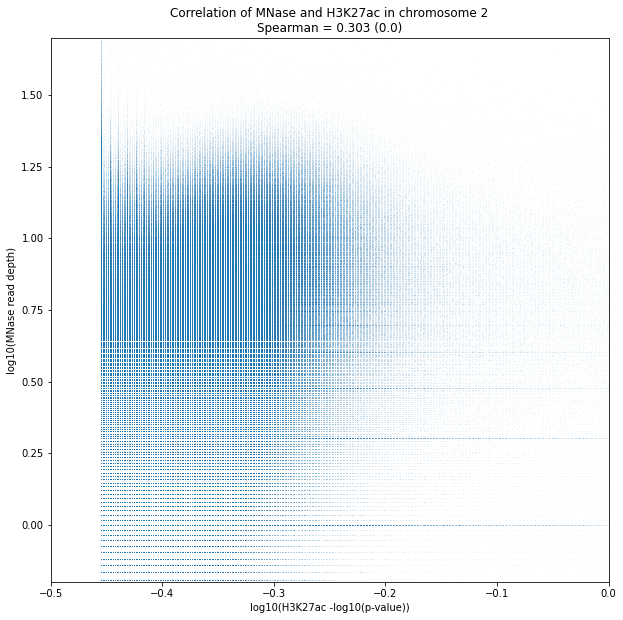

In [6]:
# Correlation of H3K27ac and MNase in HEK293 
df_pair = df_sorted_unique[(df_sorted_unique["assay_index"] == 1) | (df_sorted_unique["assay_index"] == 10)]
df_1 = df_pair.iloc[range(0,len(df_pair),2), 0:400].to_numpy().flatten()
df_10 = df_pair.iloc[range(1,len(df_pair),2), 0:400].to_numpy().flatten()

df_1 = np.load("../Data/Transformed_25bp_Data/T13A01.chr2.npy")
df_10 = np.load("../Data/Transformed_25bp_Data/T13A10.chr2.npy")

pc, pp = pearsonr(df_1, df_10)
sc, sp = spearmanr(df_1, df_10)

plt.rcParams["figure.figsize"] = (10, 10)
plt.xlim(-0.5, 0)
plt.ylim(-0.2, 1.7)
plt.xlabel("log10(H3K27ac -log10(p-value))")
plt.ylabel("log10(MNase read depth)")
plt.plot(np.log10(df_1), np.log10(df_10), 'o', markersize=0.01)
plt.title("Correlation of MNase and H3K27ac in chromosome 2\nSpearman = "+str(round(sc, 3))+" ("+str(round(sp, 3))+")")
plt.show()